In [3]:
import cv2         
import numpy as np  
import pydicom
import matplotlib.pyplot as plt
import os
import SimpleITK as sitk
from PIL import Image
from skimage.measure import find_contours
from skimage.draw import polygon2mask
np.set_printoptions(threshold=np.inf)

### METHOD 1 
#### (Otsu Thresholding and then contouring to fill holes)

Threshold value: 44.0


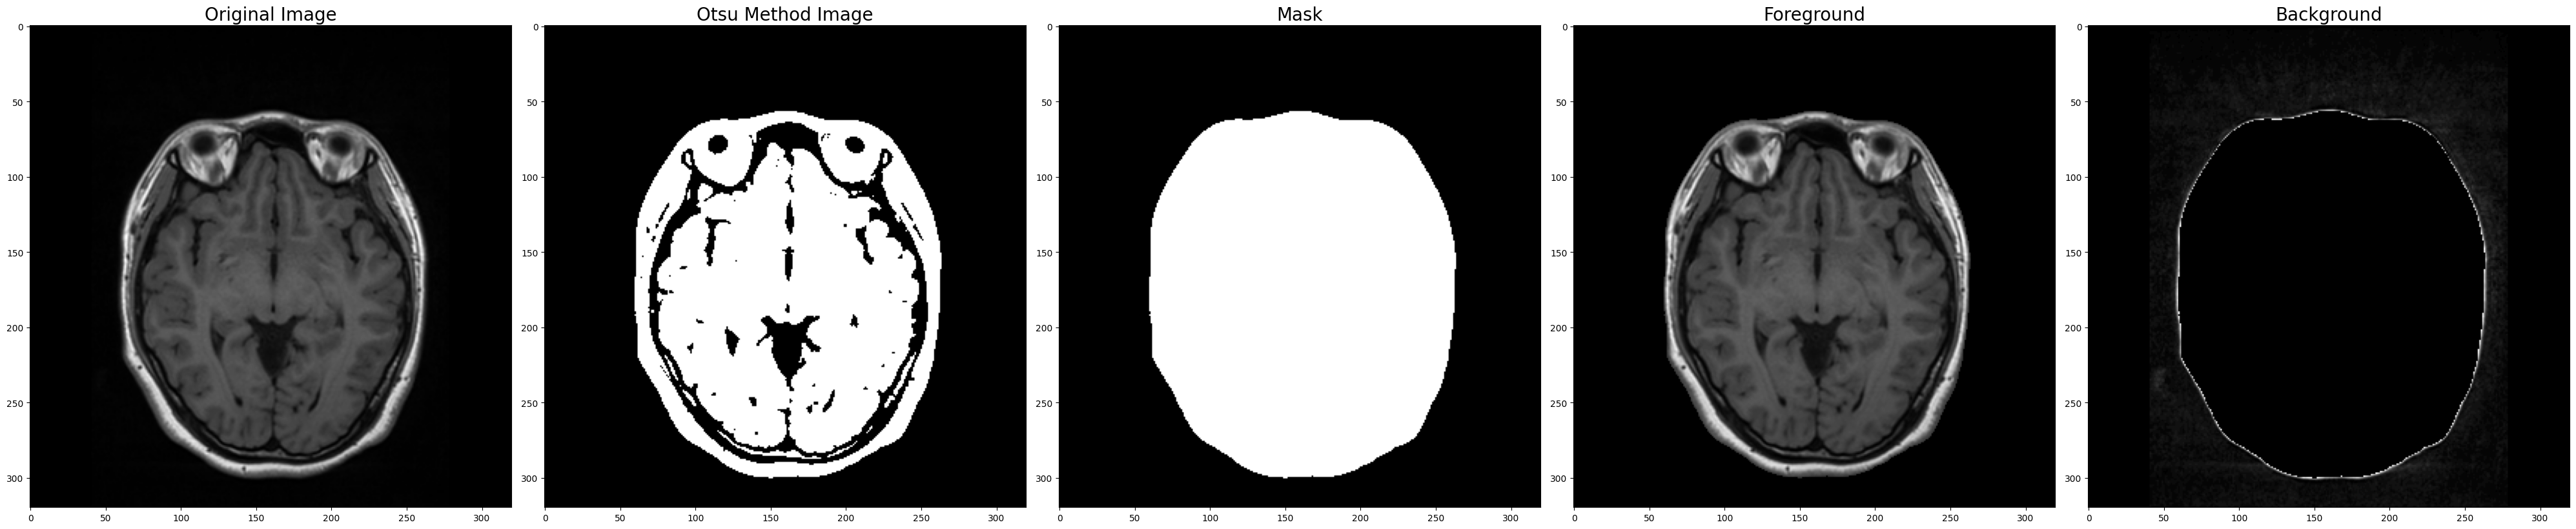

In [33]:
file = os.path.join(os.getcwd(), 'test.dcm')

#Read dicom file
img = pydicom.dcmread(file)
img = img.pixel_array

# Normalize the Image
normalize = img / np.iinfo(img.dtype).max

# Convert the normalized image to 8-bit
normalize = cv2.normalize(normalize, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)


# Apply Otsu threshold

ret, thresh1 = cv2.threshold(normalize,0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

print(f"Threshold value: {ret}")



### VERY IMPORTANT
# Threshold the image
_, mask = cv2.threshold(normalize, ret, 255, cv2.THRESH_BINARY)

# Find contours in the binary image
contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Fill in the contours
for contour in contours:
    cv2.drawContours(mask, [contour], 0, (255), thickness=cv2.FILLED)

inverse_mask = np.invert(mask)

# # Create a mask from the thresholded image
# mask = thresh1 > 0
# inverse_mask = np.invert(mask)


foreground = cv2.bitwise_and(normalize, normalize, mask=mask.astype("uint8"))

# To extract the background, you can invert the mask and then use it
inverse_mask = cv2.bitwise_not(mask)  # Invert the mask
background = cv2.bitwise_and(normalize, normalize, mask=inverse_mask.astype("uint8"))

# # Create new RGBA image and paste segmented part using mask
# foreground = Image.new("RGBA", img.shape, (0, 0, 0, 0))  # Create new blank (transparent) image
# image_pil = Image.fromarray(normalize).convert("RGBA")  # Convert the normalized image to RGBA
# foreground.paste(image_pil, mask=mask)  # Paste in the segmented part using the mask




#DISPLAY
plt.figure(figsize=(40,20))

plt.subplot(1,5,1)
plt.title('Original Image',fontsize=20)
plt.imshow(normalize,cmap='gray')

plt.subplot(1,5,2)
plt.title('Otsu Method Image',fontsize=20)
plt.imshow(thresh1,cmap='gray')

plt.subplot(1,5,3)
plt.title('Mask',fontsize=20)
plt.imshow(mask,cmap='gray')

# plt.subplot(1,5,4)
# plt.title('Inverse Mask',fontsize=20)
# plt.imshow(inverse_mask,cmap='gray')

plt.subplot(1,5,4)
plt.title('Foreground',fontsize=20)
plt.imshow(foreground,cmap='gray')

plt.subplot(1,5,5)
plt.title('Background',fontsize=20)
plt.imshow(background,cmap='gray')

plt.tight_layout()





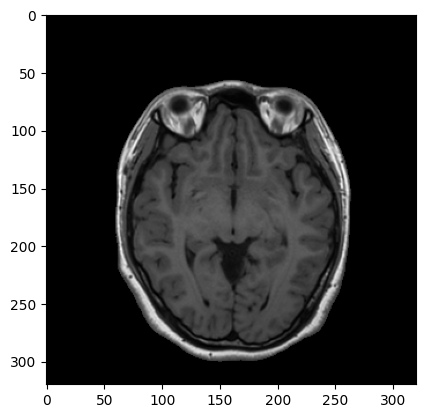

In [34]:
# SHOW DIFFERENCE

diff = cv2.absdiff(normalize,background)
plt.imshow(diff, cmap='gray')

### METHOD 2
#### (Same as before but with blur and different parameters for the contour)



In [44]:

# Load DICOM data

file = os.path.join(os.getcwd(), 'test.dcm')
ds = pydicom.dcmread(file)
img = ds.pixel_array

# Normalize the Image
normalize = img / np.iinfo(img.dtype).max

# Convert the normalized image to 8-bit
normalize = cv2.normalize(normalize, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

# Apply Gaussian blur
normalize = cv2.GaussianBlur(normalize, (1, 1), 0)

# Otsu's thresholding
_, img_thresh = cv2.threshold(normalize, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Morphological operations
kernel = np.ones((10, 10), np.uint8)
img_open = cv2.morphologyEx(img_thresh, cv2.MORPH_CLOSE, kernel, iterations = 2)

# Find largest contour
contours, _ = cv2.findContours(img_open, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnt = max(contours, key = cv2.contourArea)

# Create mask
mask = np.zeros_like(normalize)
cv2.drawContours(mask, [cnt], -1, (255), thickness=cv2.FILLED)


### TO save as png file

# Convert mask to PIL Image for easier manipulation
mask = Image.fromarray(mask)

foreground = Image.new("RGBA", img.shape, (0, 0, 0, 0))  # Create new blank (transparent) image
image_pil = Image.fromarray(normalize).convert("RGBA")  # Convert the normalized image to RGBA
foreground.paste(image_pil, mask=mask)  # Paste in the segmented part using the mask

# Display the resulting image
foreground.save(os.path.join(os.getcwd(), os.path.basename(file) + '_segmented.png'))

# # Apply mask to original image
# img_brain = cv2.bitwise_and(normalize, normalize, mask=mask.astype("uint8"))

# #DISPLAY
# plt.figure(figsize=(40,20))

# plt.subplot(1,5,1)
# plt.title('Original Image',fontsize=20)
# plt.imshow(normalize,cmap='gray')

# plt.subplot(1,5,2)
# plt.title('Otsu Method Image',fontsize=20)
# plt.imshow(img_thresh,cmap='gray')

# plt.subplot(1,5,3)
# plt.title('Image Open',fontsize=20)
# plt.imshow(img_open,cmap='gray')

# plt.subplot(1,5,4)
# plt.title('Mask',fontsize=20)
# plt.imshow(mask,cmap='gray')

# plt.subplot(1,5,5)
# plt.title('Foreground',fontsize=20)
# plt.imshow(img_brain,cmap='gray')



### METHOD 2
#### (Using sitk and adaptive threshold only: NOT GOOD)

In [31]:
# Read DICOM file
file = os.path.join(os.getcwd(), 'test.dcm')
img = sitk.ReadImage(file)
img_array = sitk.GetArrayFromImage(img)

# Normalize the image
img_array = img_array / np.iinfo(img_array.dtype).max

# Convert the normalized image to 8-bit
img_array = (img_array * 255).astype(np.uint8)

# Initialize an empty list to store the processed slices
foreground_slices = []

# Iterate over each slice in the volume
for slice in img_array:

    # Normalize the slice
    normalize = cv2.normalize(slice, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

    # Apply Adaptive threshold
    adaptive_thresh = cv2.adaptiveThreshold(normalize, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 3,1)

    # Create a mask from the thresholded image
    mask = adaptive_thresh > 0

    # Convert mask to PIL Image for easier manipulation
    mask_pil = Image.fromarray((mask * 255).astype(np.uint8), mode="L")

    # Create new RGBA image and paste segmented part using mask
    foreground = Image.new("RGBA", (slice.shape[1], slice.shape[0]), (0, 0, 0, 0))  # Create new blank (transparent) image
    image_pil = Image.fromarray(normalize).convert("RGBA")  # Convert the normalized image to RGBA
    foreground.paste(image_pil, mask=mask_pil)  # Paste in the segmented part using the mask

    # Add the processed slice to the list
    foreground_slices.append(foreground)

# At this point, 'foreground_slices' is a list of PIL Images, each representing a slice of the original volume.
# You can now display or save these slices as needed. For example, to display the first slice:
foreground_slices[0].show()